In [1]:
import zipfile
import os
import numpy as np 
from keras.layers import Dense,Flatten,Input
from keras.models import Model 
from keras.applications import ResNet50,VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"karthicktj","key":"d9816e97a435a5ca4dbaf652bc500351"}'}

In [3]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d slothkong/10-monkey-species

mkdir: cannot create directory ‘/root/.kaggle’: File exists
10-monkey-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
basefile = "/content/10-monkey-species.zip"
monkey = zipfile.ZipFile(basefile ,"r")
monkey.extractall("monkey")
monkey.close()



In [5]:
train_data = "/content/monkey/training/training"
test_data =  "/content/monkey/validation/validation"


In [6]:
IMAGE_SIZE = [224,224]
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
for layers in resnet.layers:        #pretrained model set as false
  layers.trainable = False
  

In [8]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
from glob import glob
train_folder = glob("/content/monkey/training/training/*")
print(train_folder)

['/content/monkey/training/training/n7', '/content/monkey/training/training/n9', '/content/monkey/training/training/n3', '/content/monkey/training/training/n4', '/content/monkey/training/training/n0', '/content/monkey/training/training/n5', '/content/monkey/training/training/n1', '/content/monkey/training/training/n2', '/content/monkey/training/training/n8', '/content/monkey/training/training/n6']


In [10]:
#list the directory
print(os.listdir("/content/monkey/training/training"))

['n7', 'n9', 'n3', 'n4', 'n0', 'n5', 'n1', 'n2', 'n8', 'n6']


In [27]:
from keras.layers import Dropout ,Conv2D,MaxPooling2D
from keras.models import Sequential
model = Sequential([Conv2D(16 , (3,3),activation = "relu" ,input_shape = (150,150,3)),
                    MaxPooling2D(2,2),
                    Conv2D(32 ,(3,3), activation = "relu" ,padding = "same"),
                    MaxPooling2D(2,2),
                    Conv2D(64 ,(3,3),activation = "relu" ,padding = "same"),
                    MaxPooling2D(2,2),
                    Conv2D(128 ,(3,3),activation = "relu" ,padding = "same" ),
                    MaxPooling2D(2,2),
                    Conv2D(256 ,(3,3),activation = "relu" ,padding = "same" ),
                    MaxPooling2D(2,2),
                    Dropout(0.3),
                    Flatten(),
                    Dense(1024 , activation = "relu"),
                    Dense(512 ,activation="relu"),
                    Dense(256 , activation = "relu"),
                    Dense(128 , activation = "relu"),
                    Dropout(0.3),
                    Dense(len(train_folder),activation = "softmax")
])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       7

In [29]:
#compiling my model
adam = Adam(learning_rate = 0.001)
model.compile(optimizer="adam" ,metrics = ["accuracy"] ,loss = "categorical_crossentropy")

In [30]:
train_gen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')




train_d = train_gen.flow_from_directory(train_data ,  batch_size = 64 , class_mode = "categorical" ,target_size = (150,150))


Found 1098 images belonging to 10 classes.


In [31]:
print(os.listdir(test_data))

['n7', 'n9', 'n3', 'n4', 'n0', 'n5', 'n1', 'n2', 'n8', 'n6']


In [32]:
validate_gen = ImageDataGenerator(rescale= 1./255) # rescaling image
test_d = validate_gen.flow_from_directory(test_data ,  batch_size = 64 , class_mode = "categorical" ,target_size = (150,150))

Found 272 images belonging to 10 classes.


In [33]:
#bulid a model
history  = model.fit_generator(train_d,epochs = 100 ,validation_data = test_d , steps_per_epoch = len(train_d) , validation_steps=len(test_d))

Epoch 1/100
18/18 [==============================] - 69s 4s/step - loss: 2.3093 - accuracy: 0.0920 - val_loss: 2.3004 - val_accuracy: 0.1103
Epoch 2/100
18/18 [==============================] - 63s 4s/step - loss: 2.2949 - accuracy: 0.1102 - val_loss: 2.2647 - val_accuracy: 0.1103
Epoch 3/100
18/18 [==============================] - 63s 4s/step - loss: 2.2949 - accuracy: 0.1047 - val_loss: 2.3007 - val_accuracy: 0.1029
Epoch 4/100
18/18 [==============================] - 63s 4s/step - loss: 2.3028 - accuracy: 0.0947 - val_loss: 2.2945 - val_accuracy: 0.1213
Epoch 5/100
18/18 [==============================] - 63s 4s/step - loss: 2.2734 - accuracy: 0.1193 - val_loss: 2.2339 - val_accuracy: 0.1838
Epoch 6/100
18/18 [==============================] - 63s 4s/step - loss: 2.2446 - accuracy: 0.1293 - val_loss: 2.1264 - val_accuracy: 0.1875
Epoch 7/100
18/18 [==============================] - 66s 4s/step - loss: 2.1265 - accuracy: 0.1967 - val_loss: 2.0637 - val_accuracy: 0.2353
Epoch 8/100
1

In [34]:
model.save("monkey.h5")

In [40]:
history.history

{'accuracy': [0.09198542684316635,
  0.11020036786794662,
  0.10473588109016418,
  0.09471766650676727,
  0.11930783092975616,
  0.12932604551315308,
  0.19672131538391113,
  0.21584700047969818,
  0.2540983557701111,
  0.2668488025665283,
  0.26229506731033325,
  0.28324225544929504,
  0.2959927022457123,
  0.3169398903846741,
  0.30692166090011597,
  0.3196721374988556,
  0.3233151137828827,
  0.34608379006385803,
  0.3442623019218445,
  0.32513660192489624,
  0.346994549036026,
  0.3606557250022888,
  0.340619295835495,
  0.37978142499923706,
  0.3724954426288605,
  0.3724954426288605,
  0.4162113070487976,
  0.43169400095939636,
  0.43989071249961853,
  0.4508196711540222,
  0.4754098355770111,
  0.4863387942314148,
  0.4690346121788025,
  0.5154827237129211,
  0.5291438698768616,
  0.5145719647407532,
  0.5200364589691162,
  0.5391620993614197,
  0.5455373525619507,
  0.5573770403862,
  0.5400728583335876,
  0.562841534614563,
  0.6065573692321777,
  0.5992714166641235,
  0.588342

In [42]:
history.evaluate()

AttributeError: ignored

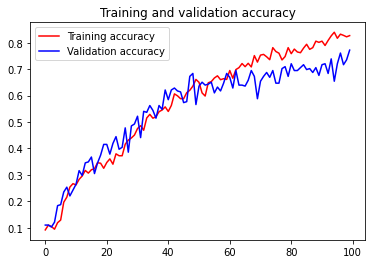

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

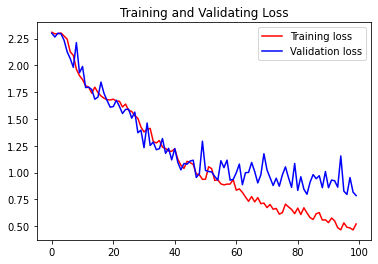

<Figure size 432x288 with 0 Axes>

In [45]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validating Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [48]:
ypred = model.predict(test_d)
ypred

array([[6.0248545e-05, 6.6597164e-01, 3.1937152e-04, ..., 7.5304568e-02,
        1.3898226e-03, 3.1241351e-03],
       [8.9316326e-01, 3.3219212e-13, 2.2914841e-13, ..., 7.1410735e-09,
        2.6894572e-06, 1.0662279e-01],
       [2.8410633e-04, 2.5986069e-01, 2.0647061e-03, ..., 5.7499284e-01,
        1.9961298e-03, 5.3868345e-03],
       ...,
       [2.8083953e-03, 7.5237341e-03, 5.2704662e-04, ..., 1.4485789e-02,
        9.0686506e-01, 2.5705020e-03],
       [6.1729802e-06, 1.1911436e-03, 4.8611403e-04, ..., 2.9440907e-05,
        1.6661518e-03, 9.7619617e-05],
       [3.7837178e-03, 1.8555355e-01, 2.2865463e-02, ..., 5.7053024e-01,
        9.4525397e-02, 2.0815082e-02]], dtype=float32)

In [73]:

from google.colab import files
from keras.preprocessing import image

#uploaded=files.upload()


 
  # predicting images
path="/content/monkey/training/training/n2/n2017.jpg"
img=image.load_img(path, target_size=(150, 150))
  
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=10)
pred = np.argmax(classes ,axis = 1)
if pred == 0:
  print( "is a martled howler")
elif pred == 1:
  print(fn  + "is patas_monkey")
elif pred == 2:
  print("japanese_macaque")
else:
  print("pigmy")
  
 

japanese_macaque
